# Homework 2

## Task 1 - Feature Selection

### Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
#from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 

dataset = pd.read_csv("magic04.data", names=["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"])
dataset = dataset.replace({'class': {'g': 1, 'h': 0}})
dataset.head()

/home/pedro/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,length,width,size,conc,conc1,asym,m3long,m3trans,alpha,dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


The datasat is composed of the following attributes:

1.  length:  continuous - major axis of ellipse [mm]
2.  width:   continuous - minor axis of ellipse [mm] 
3.  size:    continuous - 10-log of sum of content of all pixels [in #phot]
4.  conc:    continuous - ratio of sum of two highest pixels over fSize  [ratio]
5.  conc1:   continuous - ratio of highest pixel over fSize  [ratio]
6.  asym:    continuous - distance from highest pixel to center, projected onto major axis [mm]
7.  m3Long:  continuous - 3rd root of third moment along major axis  [mm] 
8.  m3Trans: continuous - 3rd root of third moment along minor axis  [mm]
9.  alpha:   continuous - angle of major axis with vector to origin [deg]
10. dist:    continuous - distance from origin to center of ellipse [mm]
11. class:   g,h        - gamma (signal), hadron (background)

### Calculate the Pearson's Correlation

In [2]:
## The data features is the data structure where we will save the features from the dataset, 
## excluding the class feature as that is the one we will want to predict

data_features = dataset.drop(['class'], axis=1)


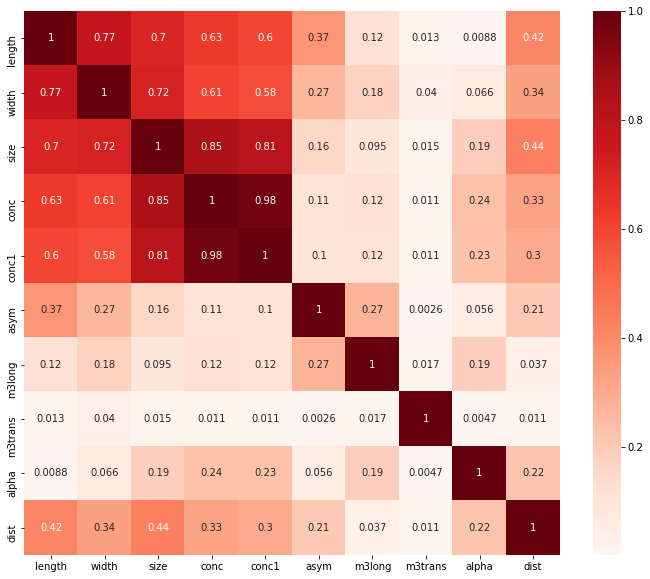

In [3]:
# Now we create the correlation matrix, which will show us how each feature correlates with
# one another, where an absolute value higher than 0.5 can be considered as somewhat correlated

corr_matrix = data_features.corr().abs()

## Code to showcase the matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [4]:
def drop_features(ds, corr, threshold=0.8):
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return ds.drop(ds[to_drop], axis=1)

reduced_dataset = drop_features(dataset, corr_matrix)
reduced_dataset.head()

,length,width,size,asym,m3long,m3trans,alpha,dist,class
0,28.7967,16.0021,2.6449,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,-5.5277,28.5525,21.8393,4.6480,356.4620,1


The normal criteria to reduce features based on the correlation value is to take out features with a high enough value, usually it's considered anything above 0.8 as highly correlated, and can be therefore taken out.

Taking this into accoun we have taken out 2 features:
 - conc and conc1 since both are highly correlated with the feature size; this is expected, since both are calculated as the ratio of a component in the picture with the size
 
Since this is not enough features being taken out, we have decided to lower the threshold to the absolute minimum to see if we'd be able to come down only to 2 features, as per requested

In [5]:
reduced_dataset = drop_features(dataset, corr_matrix, threshold=0.5)
reduced_dataset.head()

,length,asym,m3long,m3trans,alpha,dist,class
0,28.7967,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,-5.5277,28.5525,21.8393,4.6480,356.4620,1


Since the .5 value is used as to mean two features are *somewhat* related to one another, lowering the value would mean taking out features that are not at all related to one another. So this means that, as it stands, the length, asym, m3long, m3trans, alpha and dist are practically independent features that cannot be taken out. This means, using the correlation method to reduce the number of features is not an effective way of reducing the dataset to only two features.

### Calculate the ANOVA rank

On that note, we will now try the same thing, but using the ANOVA rank method as taught in class.

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

N=30


data_features=(data_features-data_features.min())/(data_features.max()-data_features.min())

k_bestfeatures = SelectKBest(score_func = f_classif)
rankings = k_bestfeatures.fit(data_features, dataset['class'])
b=list(rankings.scores_)
a=list(range(0,len(b)))
cols=data_features.columns.values.tolist()



sf = [g for _,g in sorted(zip(b,a))]
sf=sf[len(a)-N:len(a)]
c=1
sf=reversed(sf)
print(['order','index', 'column name','f-score'])
inx=[]
for chosen in sf:
    print(str(c)+'º:', chosen, cols[chosen], b[chosen], sep='\t')
    c+=1
    inx.append(chosen)
print(inx)

['order', 'index', 'column name', 'f-score']
1º:	8	alpha	5131.902635916672
2º:	0	length	1987.0965571351253
3º:	1	width	1443.3754692845985
4º:	6	m3long	739.0532981028394
5º:	5	asym	590.8648238187989
6º:	2	size	267.59859309282325
7º:	9	dist	81.19801711800942
8º:	3	conc	11.5294983768614
9º:	4	conc1	0.4376871076678041
10º:	7	m3trans	0.28002684780683884
[8, 0, 1, 6, 5, 2, 9, 3, 4, 7]


Calculating the ranking of the features with the F-score, we can see that the best features to use in this dataset are alpha and length. The F score is the ration of variance between group averages and variance within the group itself. In this case, there's two groups for each feature, the group with a gamma class and the group with a hadron class.

Using this value for each feature, we can rank them and choose the two features with the largest f score, as it means that the variance between the groups is so much larger than the variance within the group. This ranking shows us that the alpha and lenght feature are the two best for the classification of the example.

However, we must note that the F-score for a lot of the other values are relatively high themselves, as we have a lot of features with an F-score above 500. This may mean that these two features aren't good enough to check the classes.

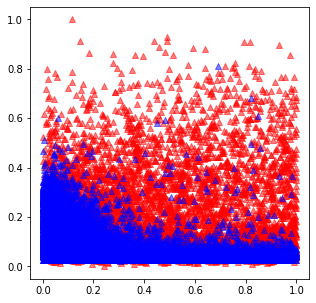

In [23]:
reduced_df = dataset[['alpha', 'length']]
y_df = dataset['class']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

ax.scatter(reduced_df['alpha'][y_df == 0], reduced_df['length'][y_df == 0],
              color='red', marker='^', alpha=0.5)
ax.scatter(reduced_df['alpha'][y_df == 1], reduced_df['length'][y_df == 1],
              color='blue', marker='^', alpha=0.5)

This shows that these two features simply aren't enough to distinguish both classes, as there's a clear intersection of values that cannot be separated easily

### Dimension Reduction with PCA

6688
12332
6688
12332


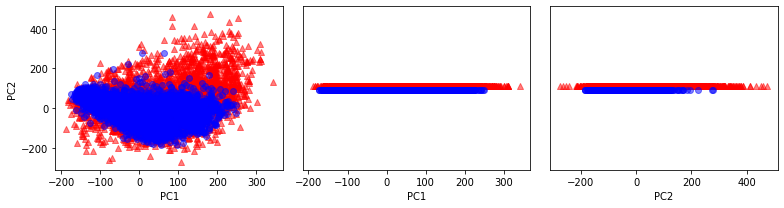

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_features)
y_df = dataset['class']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))

ax[0].scatter(df_pca[y_df == 0, 0], df_pca[y_df == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(df_pca[y_df == 1, 0], df_pca[y_df == 1, 1],
              color='blue', marker='o', alpha=0.5)

inx=sum(y_df==0)
print(inx)
ax[1].scatter(df_pca[y_df == 0, 0], np.zeros((inx, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
inx=sum(y_df==1)
print(inx)
ax[1].scatter(df_pca[y_df == 1, 0], np.zeros((inx, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

inx=sum(y_df==0)
print(inx)
ax[2].scatter(df_pca[y_df == 0, 1], np.zeros((inx, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
inx=sum(y_df==1)
print(inx)
ax[2].scatter(df_pca[y_df == 1, 1], np.zeros((inx, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[2].set_ylim([-1, 1])
ax[2].set_yticks([])
ax[2].set_xlabel('PC2')

plt.tight_layout()
# plt.savefig('./figures/half_moon_2.png', dpi=300)
plt.show()

### Dimension Reduction with KPCA

6688
12332
6688
12332


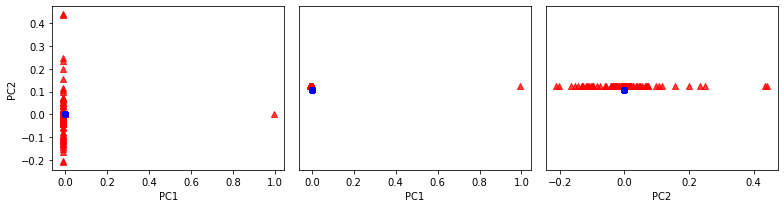

In [11]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
df_kpca = kpca.fit_transform(data_features)
y_df = dataset['class']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))

ax[0].scatter(df_kpca[y_df == 0, 0], df_kpca[y_df == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(df_kpca[y_df == 1, 0], df_kpca[y_df == 1, 1],
              color='blue', marker='o', alpha=0.5)

inx=sum(y_df==0)
print(inx)
ax[1].scatter(df_kpca[y_df == 0, 0], np.zeros((inx, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
inx=sum(y_df==1)
print(inx)
ax[1].scatter(df_kpca[y_df == 1, 0], np.zeros((inx, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

inx=sum(y_df==0)
print(inx)
ax[2].scatter(df_kpca[y_df == 0, 1], np.zeros((inx, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
inx=sum(y_df==1)
print(inx)
ax[2].scatter(df_kpca[y_df == 1, 1], np.zeros((inx, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[2].set_ylim([-1, 1])
ax[2].set_yticks([])
ax[2].set_xlabel('PC2')

plt.tight_layout()
plt.show()

With both of the KPCA and the PCA methods we see that the data is still to jumbled together to properly distinguish the class of each example with only two features, further proving what we have seen in the other feature reducing methods.